In [503]:
import os
import sys
import cv2
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

target_path = "/Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/code_projects/isd-annotator" 
os.chdir(target_path)
print("Changed working directory to:", os.getcwd())


sys.path.append('/Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/code_projects/isd-annotator/Depth-Anything-V2')
from depth_anything_v2.dpt import DepthAnythingV2

Changed working directory to: /Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/code_projects/isd-annotator


## Surface Normal Dev

In [504]:
def compute_surface_normals(depth):
    # Apply bilateral filter to smooth depth

    for _ in range(5):
        depth = cv2.bilateralFilter(depth, d=7, sigmaColor=75, sigmaSpace=70)
        # depth = cv2.bilateralFilter(depth, d=9, sigmaColor=75, sigmaSpace=70)
    
    # Compute Sobel gradients (tangent vectors)
    sobel_x = cv2.Sobel(depth, cv2.CV_32F, 1, 0, ksize=5) / 4  
    sobel_y = cv2.Sobel(depth, cv2.CV_32F, 0, 1, ksize=5) / 4  
    # Create normal map
    # [1,0,dx]x[0,1,dy] = [-dx,-dy,1]
    normal = np.zeros((depth.shape[0], depth.shape[1], 3), dtype=np.float32)
    normal[..., 0] = -sobel_x  # Nx
    normal[..., 1] = sobel_y # Ny
    normal[..., 2] = 1        # Nz 
    norm = np.sqrt(sobel_x**2 + sobel_y**2 + normal[..., 2]**2)
    normal[..., 0] = normal[..., 0]/norm
    normal[..., 1] = normal[..., 1]/norm
    normal[..., 2] = normal[..., 2]/norm

    return normal

def colorize_normals(normal):
    height, width, _ = normal.shape
    color_normals = np.zeros((height, width, 3), dtype=np.uint8)
    color_normals= normal
    up = np.zeros((height, width), dtype=np.uint8)
    front = np.zeros((height, width), dtype=np.uint8)
    side = np.zeros((height, width), dtype=np.uint8)
    up = (normal[...,1])
    front = (normal[...,2])
    side= (normal[...,0])

    return (color_normals+1)/2,(up+1)/2,(front+1)/2,(side+1)/2

def array_to_grayscale_img(arr):

    arr_min = arr.min()
    arr_max = arr.max()
    
    # Avoid division by zero
    if arr_max - arr_min < 1e-8:
        norm_arr = np.zeros_like(arr, dtype=np.uint8)
    else:
        norm_arr = ((arr - arr_min) / (arr_max - arr_min)).astype(np.float32)
    
    return (norm_arr*255).astype(np.uint8)

def convert_16bit_to_8bit(image_16bit):

    return (255 * (image_16bit / 65535)).astype(np.uint8)


def visualize_labels(label_map):
    colormap = np.array([[255,0,0], [0,255,0], [0,0,255]], dtype=np.uint8)
    vis = colormap[label_map % 3]
    return vis

In [505]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    # 'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    # 'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    # 'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits' # or 'vitl', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'/Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/code_projects/isd-annotator/Depth-Anything-V2/checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE).eval()


In [506]:
print("--------------------")
print("Original Image")
image_16bit = cv2.imread("/Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/code_projects/isd-annotator/images/example_folder/wenqing_fan_079.tif", cv2.IMREAD_UNCHANGED)
image_8bit = convert_16bit_to_8bit(image_16bit)
print(image_8bit.shape)
# print(image_8bit)
cv2.imwrite("process_images/original_image.png", image_8bit)
depth_unscaled = model.infer_image(image_8bit)
print("--------------------")
print("Unscaled Depth Map")
print(depth_unscaled.shape)
# print(depth_unscaled)
print("--------------------")
print("Scaled Depth Map")
depth_img = array_to_grayscale_img(depth_unscaled)
print(depth_img.shape)
# print(depth_img)
cv2.imwrite("process_images/depth_map.png", depth_img)
print("--------------------")
print("Normal Map")
normal_map = compute_surface_normals(depth_img)
print(normal_map.shape)
# print(normal_map)
print("--------------------")
colored_normals,up,front,side = colorize_normals(normal_map)
cv2.imwrite("process_images/colored_normals1.png", (colored_normals*255).astype(np.uint8))
colored_normals_smoothed = cv2.bilateralFilter(colored_normals, d=50, sigmaColor=75, sigmaSpace=70)
cv2.imwrite("process_images/colored_normals_smooth.png", (colored_normals_smoothed*255).astype(np.uint8))
cv2.imwrite("process_images/up.png", (up*255).astype(np.uint8))
cv2.imwrite("process_images/front.png", (front*255).astype(np.uint8))
cv2.imwrite("process_images/side_side.png", (side*255).astype(np.uint8))
print("--------------------")


--------------------
Original Image
(1024, 1533, 3)
--------------------
Unscaled Depth Map
(1024, 1533)
--------------------
Scaled Depth Map
(1024, 1533)
--------------------
Normal Map
(1024, 1533, 3)
--------------------
--------------------


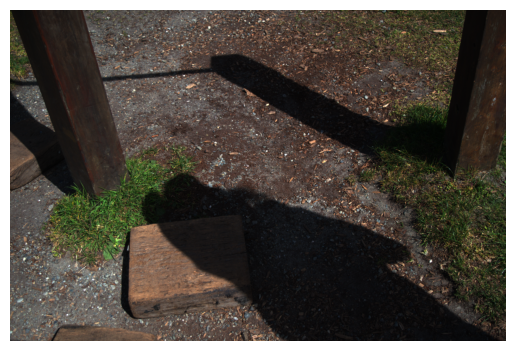

In [507]:
plt.imshow(cv2.cvtColor(image_8bit, cv2.COLOR_BGR2RGB))
plt.axis(False);


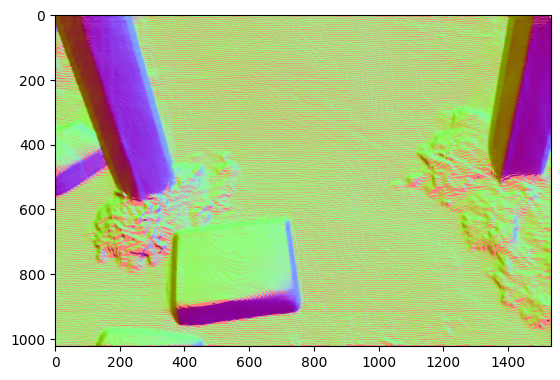

In [508]:
plt.imshow(cv2.cvtColor(colored_normals, cv2.COLOR_BGR2RGB));


In [509]:
(np.unique(colored_normals))

array([4.4703484e-07, 5.3644180e-07, 8.0466270e-07, ..., 9.9999970e-01,
       9.9999976e-01, 1.0000000e+00], dtype=float32)

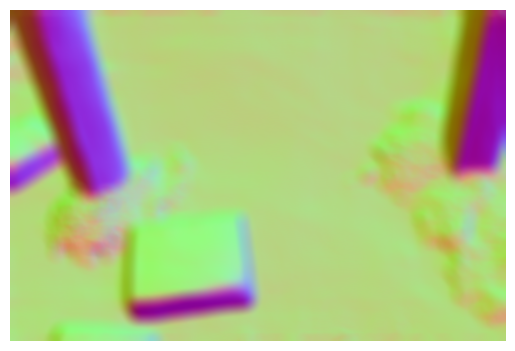

In [510]:
plt.imshow(cv2.cvtColor(colored_normals_smoothed, cv2.COLOR_BGR2RGB))
plt.axis(False);

In [511]:
colored_normals_smoothed

array([[[0.06127328, 0.300424  , 0.51128054],
        [0.06076937, 0.30075812, 0.51126546],
        [0.06060275, 0.3009144 , 0.51128274],
        ...,
        [0.54404986, 0.18159343, 0.64452356],
        [0.5450341 , 0.18177916, 0.64485365],
        [0.54556423, 0.18195967, 0.64519536]],

       [[0.06118532, 0.30056065, 0.5112811 ],
        [0.06072557, 0.30081296, 0.5112676 ],
        [0.06062434, 0.300851  , 0.5112839 ],
        ...,
        [0.54420656, 0.18090904, 0.64372337],
        [0.5451493 , 0.18102334, 0.6440241 ],
        [0.5453832 , 0.18108584, 0.6440748 ]],

       [[0.06095511, 0.3008606 , 0.5112856 ],
        [0.06056673, 0.30101475, 0.51127005],
        [0.0606394 , 0.30082014, 0.5112875 ],
        ...,
        [0.5443041 , 0.1804508 , 0.6429409 ],
        [0.544909  , 0.18020098, 0.6429883 ],
        [0.54494065, 0.18007226, 0.64291024]],

       ...,

       [[0.5250702 , 0.8991877 , 0.6606251 ],
        [0.52505183, 0.8991839 , 0.66062784],
        [0.5249613 , 0

(1024, 1533, 3)


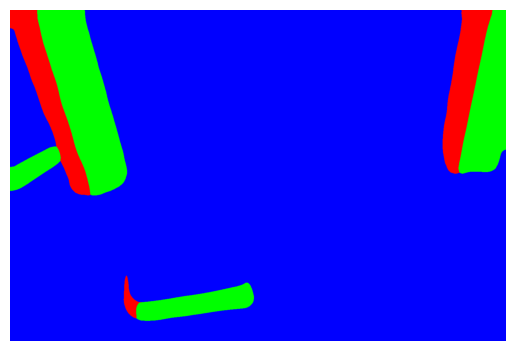

In [512]:
h,w,c = colored_normals_smoothed.shape
colored_normals_smoothed_flatten = colored_normals_smoothed.reshape(h*w, colored_normals_smoothed.shape[2])

compactness, labels, centers = cv2.kmeans(colored_normals_smoothed_flatten.astype(np.float32), K=3,
                                           bestLabels=None,
                                           criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0),
                                           attempts=10,
                                           flags=cv2.KMEANS_PP_CENTERS)
label_map = labels.flatten().reshape((h, w)).astype(np.uint8)
viz = visualize_labels(label_map)
print(viz.shape)
# print(viz)
# cv2.imwrite("process_images/segmentation.png", cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))
plt.imshow(cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))
plt.axis(False);


True

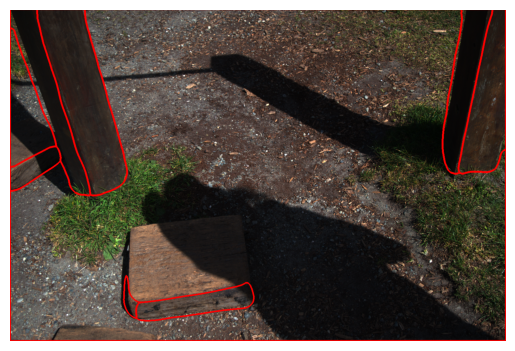

In [513]:
output = image_8bit.copy()

for cluster_id in range(3):
    mask = (label_map == cluster_id).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(output, contours, -1, (0, 0, 255), 3)  # Red contours

plt.imshow(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
plt.axis(False);

cv2.imwrite("kmeans_boundaries.jpg", output)

## Depth Class

In [514]:
import torch
from depth_anything_v2.dpt import DepthAnythingV2

class DepthAnythingLoader:
    def __init__(self, encoder='vits', checkpoint_dir=None, device=None):
        """
        Initializes the DepthAnythingV2 model with the specified encoder and loads pretrained weights.

        Args:
            encoder (str): One of {'vits', 'vitb', 'vitl', 'vitg'}.
            checkpoint_dir (str): Path to directory containing the .pth model file.
            device (str or torch.device): Torch device to load the model onto.
        """
        self.encoder = encoder
        self.checkpoint_dir = checkpoint_dir or './checkpoints'
        self.device = device or ('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

        self.model_configs = {
            'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
            'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
            'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
            'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
        }

        self.model = self._load_model()

    def _load_model(self):
        config = self.model_configs[self.encoder]
        model = DepthAnythingV2(**config)
        ckpt_path = f"{self.checkpoint_dir}/depth_anything_v2_{self.encoder}.pth"
        state_dict = torch.load(ckpt_path, map_location='cpu')
        model.load_state_dict(state_dict)
        return model.to(self.device).eval()

    def get_model(self):
        return self.model
    
encoder = 'vits'
checkpoint_dir = 'Depth-Anything-V2/checkpoints'
model_loader = DepthAnythingLoader(encoder=encoder, checkpoint_dir=checkpoint_dir)
model = model_loader.get_model()

## Surface Normal Segmentation Class

In [515]:
import cv2
import numpy as np
import torch
from sklearn.decomposition import PCA


class NormalSegmenter:
    """
    A class to compute surface normals from a depth map, segment them into clusters
    based on normal direction, and visualize or contour the resulting segments.
    
    Attributes:
        model (callable): A depth estimation model with an `infer_image(image)` method.
        device (str): Target device (CPU/GPU).
        k (int): Number of clusters for KMeans segmentation.
    """

    def __init__(self, model=None, device=None, k=3):
        """
        Initialize the NormalSegmenter.

        Args:
            model (optional): A depth estimation model that accepts an image and returns a depth map.
            device (str, optional): 'cuda', 'cpu', or 'mps'. If None, auto-detected.
            k (int): Number of clusters for segmentation.
        """
        self.image_path = None
        self.image = None
        self.model = model
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.k = k

    def set_image_path(self, image_path):
        """Sets the path to the image for processing."""
        self.image_path = image_path

    def get_image(self):
        """
        Reads and converts the 16-bit TIFF image to 8-bit.

        Returns:
            np.ndarray: 8-bit image
        """
        if self.image is None:
            image_16bit = cv2.imread(self.image_path, cv2.IMREAD_UNCHANGED)
            self.image = self.convert_16bit_to_8bit(image_16bit)
        return self.image

    def convert_16bit_to_8bit(self, image_16bit):
        """Scales a 16-bit image to 8-bit."""
        return (255 * (image_16bit / 65535)).astype(np.uint8)

    def array_to_grayscale_img(self, arr):
        """
        Normalizes a single-channel float image to 8-bit grayscale.

        Args:
            arr (np.ndarray): Float32 array.

        Returns:
            np.ndarray: 8-bit normalized grayscale image.
        """
        arr_min, arr_max = arr.min(), arr.max()
        if arr_max - arr_min < 1e-8:
            norm_arr = np.zeros_like(arr, dtype=np.uint8)
        else:
            norm_arr = ((arr - arr_min) / (arr_max - arr_min)).astype(np.float32)
        return (norm_arr * 255).astype(np.uint8)

    def compute_surface_normals(self, depth):
        """
        Estimates surface normals from a depth map using Sobel filters.

        Args:
            depth (np.ndarray): Grayscale depth image.

        Returns:
            np.ndarray: Normal map of shape (H, W, 3).
        """
        for _ in range(5):
            depth = cv2.bilateralFilter(depth, d=7, sigmaColor=75, sigmaSpace=70)

        sobel_x = cv2.Sobel(depth, cv2.CV_32F, 1, 0, ksize=5) / 4
        sobel_y = cv2.Sobel(depth, cv2.CV_32F, 0, 1, ksize=5) / 4

        normal = np.zeros((*depth.shape, 3), dtype=np.float32)
        normal[..., 0] = -sobel_x
        normal[..., 1] = sobel_y
        normal[..., 2] = 1

        norm = np.sqrt(np.sum(np.square(normal), axis=2, keepdims=True))
        normal /= (norm + 1e-8)
        return normal

    def colorize_normals(self, normal):
        """
        Splits normal map into directional components and scales to [0, 1].

        Args:
            normal (np.ndarray): Normal map.

        Returns:
            Tuple[np.ndarray]: Colored normals, up, front, side components all in range [0, 1].
        """
        up = normal[..., 1]
        front = normal[..., 2]
        side = normal[..., 0]
        return (normal + 1) / 2, (up + 1) / 2, (front + 1) / 2, (side + 1) / 2

    def visualize_labels(self, label_map):
        """
        Maps integer cluster labels to RGB colors.

        Args:
            label_map (np.ndarray): 2D array of labels.

        Returns:
            np.ndarray: Color visualization of the label map.
        """
        colormap = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]], dtype=np.uint8)
        vis = colormap[label_map % self.k]
        return vis
    
    def estimate_optimal_k(self, normals, threshold=0.90):
        """
        Estimates the number of dominant directions using PCA on the surface normals.

        Args:
            normals (np.ndarray): Normal map of shape (H, W, 3).
            threshold (float): Cumulative variance threshold to select number of components.

        Returns:
            int: Suggested number of clusters (1 to 3).
        """
        h, w, _ = normals.shape
        reshaped_normals = normals.reshape(-1, 3)

        # Normalize to unit vectors for consistency
        reshaped_normals = reshaped_normals / (np.linalg.norm(reshaped_normals, axis=1, keepdims=True) + 1e-6)

        # Apply PCA
        pca = PCA(n_components=3)
        pca.fit(reshaped_normals)

        cum_var = np.cumsum(pca.explained_variance_ratio_)

        # Determine number of PCs needed to explain `threshold` variance
        for i, total_var in enumerate(cum_var):
            if total_var >= threshold:
                return max(1, i + 1)

        return 3  # fallback
    
    def cluster_segments(self, colored_normals_smoothed, normal_map=None):
        """
        Applies KMeans clustering to the normal map with adaptive k via PCA.

        Args:
            colored_normals_smoothed (np.ndarray): (H, W, 3) normal image after bilateral smoothing.
            normal_map (np.ndarray, optional): Original normal map (H, W, 3) for PCA-based k selection.

        Returns:
            np.ndarray: Label map of shape (H, W).
        """
        h, w, c = colored_normals_smoothed.shape

        # Estimate k based on PCA over raw normals
        if normal_map is not None:
            self.k = self.estimate_optimal_k(normal_map)

        reshaped = colored_normals_smoothed.reshape(h * w, c).astype(np.float32)

        _, labels, _ = cv2.kmeans(
            reshaped,
            K=self.k,
            bestLabels=None,
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0),
            attempts=10,
            flags=cv2.KMEANS_PP_CENTERS
        )
        return labels.flatten().reshape(h, w).astype(np.uint8)

    # def cluster_segments(self, colored_normals_smoothed):
    #     """
    #     Applies KMeans clustering to colored normal map.

    #     Args:
    #         colored_normals_smoothed (np.ndarray): Smoothed (H, W, 3) normal image.

    #     Returns:
    #         np.ndarray: Label map of shape (H, W).
    #     """
    #     h, w, c = colored_normals_smoothed.shape
    #     reshaped = colored_normals_smoothed.reshape(h * w, c).astype(np.float32)

    #     _, labels, _ = cv2.kmeans(
    #         reshaped,
    #         K=self.k,
    #         bestLabels=None,
    #         criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0),
    #         attempts=10,
    #         flags=cv2.KMEANS_PP_CENTERS
    #     )
    #     return labels.flatten().reshape(h, w).astype(np.uint8)

    def contour_segments(self, label_map):
        """
        Extracts contours for each segment cluster.

        Args:
            label_map (np.ndarray): Clustered label map.

        Returns:
            Dict[int, List[np.ndarray]]: Contours per cluster ID.
        """
        all_contours = {}
        for cluster_id in range(self.k):
            mask = (label_map == cluster_id).astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            all_contours[cluster_id] = contours
        return all_contours

    def draw_contours(self, contours):
        """
        Draws contours on the original image.

        Args:
            contours (dict): Dictionary of contours by cluster ID.

        Returns:
            np.ndarray: Image with drawn contours.
        """
        image = self.image.copy()
        for cluster_id, contour in contours.items():
            cv2.drawContours(image, contour, -1, (0, 0, 255), 2)
        return image

    def process_image(self, image_path):
        """
        Full pipeline: from image path → depth → normals → clusters → contours.

        Args:
            image_path (str): Path to the 16-bit input image.

        Returns:
            Tuple[np.ndarray, Dict[int, List[np.ndarray]]]:
                - label_map: 2D array of cluster labels.
                - contours: Contours per cluster.
        """
        self.set_image_path(image_path)
        self.get_image()

        if self.model is None:
            raise ValueError("No depth estimation model provided.")

        depth_unscaled = self.model.infer_image(self.image)  # float32 (H, W)
        depth_img = self.array_to_grayscale_img(depth_unscaled)

        normal_map = self.compute_surface_normals(depth_img)
        colored_normals, up, front, side = self.colorize_normals(normal_map)

        colored_normals_smoothed = cv2.bilateralFilter(colored_normals, d=50, sigmaColor=75, sigmaSpace=70)
        label_map = self.cluster_segments(colored_normals_smoothed, normal_map)
        contours = self.contour_segments(label_map)

        return label_map, contours
    
image_path = "/Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/code_projects/isd-annotator/images/example_folder/wenqing_fan_085.tif"
segmenter = NormalSegmenter(model=model, k=3)
label_map, contours = segmenter.process_image(image_path)



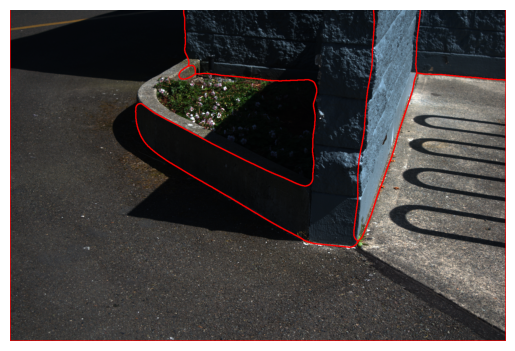

In [516]:
image = segmenter.draw_contours(contours)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show;

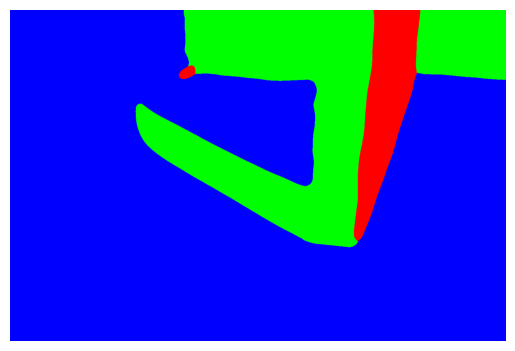

In [517]:
viz = segmenter.visualize_labels(label_map)
plt.imshow(cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))
plt.axis(False)
plt.show;

## Annotation Propagation

In [ ]:
import numpy as np

def annotation_map(self)
    
    # Calculate midpoints between the lit and shadow pairs
    midpoints = np.array([((x1 + x2) / 2, (y1 + y2) / 2) for (x1, y1), (x2, y2) in zip(self.lit_pixels, self.shadow_pixels) if x2 is not None and y2 is not None])
    
def propagate_annotations(annotation_map, segmentation_map):
    """
    Propagate annotation values to all pixels in their segment.

    Args:
        annotation_map (np.ndarray): Same shape as segmentation_map. 
                                     Pixels with annotations have values, others are np.nan or a sentinel.
        segmentation_map (np.ndarray): 2D array with segment IDs per pixel.

    Returns:
        np.ndarray: New map with propagated annotation values.
    """
    output = np.full_like(annotation_map, np.nan, dtype=np.float32)
    unique_segments = np.unique(segmentation_map)

    for seg_id in unique_segments:
        mask = segmentation_map == seg_id
        values = annotation_map[mask]
        annotated_vals = values[~np.isnan(values)]

        if len(annotated_vals) > 0:
            mean_val = np.mean(annotated_vals)
            output[mask] = mean_val

    # If any pixels are still NaN (segments with no annotation), fill with global mean
    global_annotated_vals = annotation_map[~np.isnan(annotation_map)]
    global_mean = np.mean(global_annotated_vals) if len(global_annotated_vals) > 0 else 0
    output[np.isnan(output)] = global_mean

    return output